<a href="https://colab.research.google.com/github/danmenloz/CropDamage/blob/master/Segnet_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <strong>SegNet</strong>

Image segmentation of damaged crops using SegNet arquitecture.

# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from PIL import Image

import cv2
import sklearn
from sklearn.metrics import jaccard_score, confusion_matrix

# Main Parameters

In [2]:
# Dataset
batch_size = 8 # High value could impact RAM memory
img_size = (216, 288) # Image size reduction ratio 1/16
real_size = (3456, 4608) # To estimate Jaccard Score
store_in_ram = False
use_gpu = True
store_predictions = True

# Importing Dataset

In [3]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import SegNet Model
import sys
sys.path.append('/content/drive/My Drive/ECE_542-Project_2/Colab Notebooks')
from segnet_model import SegNet

In [5]:
# Read datasets CSV file to load train, valid and test sets
import_file =  '/content/drive/My Drive/ECE_542-Project_2/Colab Notebooks/datasets.csv'
X_path = "/content/drive/My Drive/ECE_542-Project_2/Data/Train"
Y_path = "/content/drive/My Drive/ECE_542-Project_2/Data/Train-Annotations"

table = pd.read_csv(import_file)
train_files = np.asarray( pd.DataFrame.dropna(table[['train']]) ).ravel()
valid_files = np.asarray( pd.DataFrame.dropna(table[['valid']]) ).ravel()
test_files = np.asarray( pd.DataFrame.dropna(table[['test']]) ).ravel()

# add base path
trainX = [ os.path.join(X_path,f) for f in train_files ]
trainY = [ os.path.join(Y_path,f.replace('jpg','png')) for f in train_files ]
validX = [ os.path.join(X_path,f) for f in valid_files ]
validY = [ os.path.join(Y_path,f.replace('jpg','png')) for f in valid_files ]
testX = [ os.path.join(X_path,f) for f in test_files ]
testY = [ os.path.join(Y_path,f.replace('jpg','png')) for f in test_files ]

# dataX_files = np.array(glob.glob(os.path.join(X_path, "*.jpg")))
# dataY_files = np.array(glob.glob(os.path.join(Y_path, "*.png")))
# dataX_files = sorted(dataX_files) # Ensures one to one match between images and annotations
# dataY_files = sorted(dataY_files) # Ensures one to one match between images and annotations

In [6]:
# Import check
# c = 0
# for i in range(len(dataX_files)):
#   if dataX_files[i][:-4][-4:] == dataY_files[i][:-4][-4:]:
#     c += 1
# print(c)
# print(len(dataX_files))
print('trainX: %d    trainY:%d' %(len(trainX), len(trainY)) )
print('validX: %d     validY:%d' %(len(validX), len(validY)) )
print('testX: %d      testY:%d' %(len(testX), len(testY)) )


trainX: 409    trainY:409
validX: 87     validY:87
testX: 89      testY:89


In [7]:
# Class for reading data directly from csv file
class Image_Dataset(Dataset):
  # Characterizes a dataset for PyTorch
  def __init__(self, X_paths, Y_paths, transform=None):
    self.X_paths = X_paths
    self.Y_paths = Y_paths
    self.transform = transform
  
  def __len__(self):
    return len(self.X_paths)

  def __getitem__(self, index):
    x = Image.open(self.X_paths[index])
    y = Image.open(self.Y_paths[index])
    if self.transform:
      x = self.transform(x) #Resize
      y = self.transform(y)
    return x, y

In [8]:
# Length for train, valid and test data
# train_len = int(train_p * len(dataX_files) / 100)
# valid_len = int(valid_p * len(dataX_files) / 100)
# test_len = len(dataX_files) - train_len - valid_len

# Resize Image and Normalization transforms
composed = transforms.Compose([transforms.Resize(img_size, interpolation = 0), # 0: Nearest Neighbors
                               # Rotations
                               # Mirrow
                               # Increase horizontal pattern 
                               transforms.ToTensor()])

# Pytorch Datasets
train = Image_Dataset(trainX, trainY, transform = composed)
valid = Image_Dataset(validX, validY, transform = composed)
test = Image_Dataset(testX, testY, transform = composed)
# train, valid, test = random_split(dataset, [train_len, valid_len, test_len])

# Pytorch Dataloader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = True, num_workers = 2)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = True, num_workers = 2)

In [9]:
# Storing tensors in Colab RAM (Takes about 10 minutes to finish)
def save_to_tensor(data_loader):
  dataX_list = []
  dataY_list = []
  for dataX, dataY in data_loader:
    dataX_list.append(dataX)
    dataY_list.append(dataY)
  dataX_t = torch.tensor(np.vstack(dataX_list))
  dataY_t = torch.tensor(np.vstack(dataY_list))
  return dataX_t, dataY_t

if store_in_ram:
  # trainX_data, trainY_data = save_to_tensor(train_loader)
  # validX_data, validY_data = save_to_tensor(valid_loader)
  testX_data, testY_data = save_to_tensor(test_loader)
  # train = TensorDataset(trainX_data, trainY_data)
  # valid = TensorDataset(validX_data, validY_data)
  # test = TensorDataset(testX_data, testY_data)
  # train_loader = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers=2)
  # valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = True, num_workers=2)
  # test_loader = DataLoader(test, batch_size = batch_size, shuffle = True, num_workers=2)

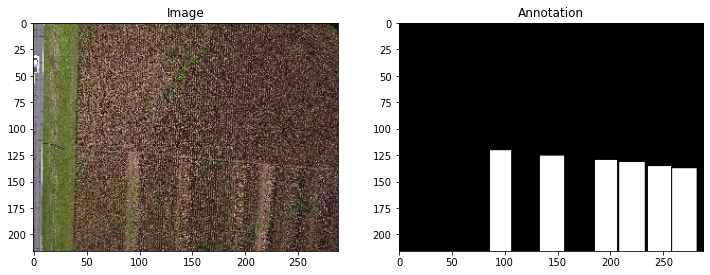

In [10]:
# Ploting original and annotation Image
N = int(np.random.uniform(high = batch_size))
img, label = iter(train_loader).next()
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
img = img[N,:,:,:].permute(1, 2, 0)
ax1.imshow(img, cmap = 'gray')
ax1.title.set_text('Image')
label = label[N,0,:,:]
ax2.imshow(label, cmap = 'gray')
ax2.title.set_text('Annotation')

In [11]:
# Samples per dataset
if store_in_ram:
  print("Samples in Train: %d" % len(trainX_data))
  print("Samples in Valid: %d" % len(validX_data))
  print("Samples in Test: %d" % len(testX_data))
else:
  print("Samples in Train: %d" % len(train.X_paths))
  print("Samples in Valid: %d" % len(valid.X_paths))
  print("Samples in Test: %d" % len(test.X_paths))

Samples in Train: 409
Samples in Valid: 87
Samples in Test: 89


## Loss Function

In [12]:
def ae_loss(recon_x, x):
  # BCE Loss
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') 
  return recon_loss

# Forward Test

## Model Definition

In [13]:
# Create model
ae_model = SegNet(input_channels=3, output_channels=1)

# Use GPU
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
ae_model = ae_model.to(device)

# Parameters
num_params = sum(p.numel() for p in ae_model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 167801129


# Evaluation

## Load best model

In [14]:
# Run model in cell above to create segnet model
model_best_path = '/content/drive/My Drive/ECE_542-Project_2/Colab Notebooks/segnet_best_sigmoid.pth'
ae_model.load_state_dict(torch.load(model_best_path))
ae_model.eval()

SegNet(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

## Test Error

In [15]:
# set to evaluation mode
test_loss_avg, num_batches = 0, 0
test_out = []
testX_data = []
testY_data = []

for test_images, test_labels in test_loader:
  testX_data.append(test_images)
  testY_data.append(test_labels)
  with torch.no_grad():
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    # vae reconstruction
    _, test_recon = ae_model(test_images)
    test_out.append(test_recon.cpu())
    # reconstruction error
    loss = ae_loss(test_recon, test_labels)
    test_loss_avg += loss.item()
    num_batches += 1

testX_data = torch.tensor(np.vstack(testX_data))
testY_data = torch.tensor(np.vstack(testY_data))
test_out = torch.tensor(np.vstack(test_out))
print( testX_data.shape, testY_data.shape, test_out.shape  )
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

torch.Size([89, 3, 216, 288]) torch.Size([89, 1, 216, 288]) torch.Size([89, 1, 216, 288])
average reconstruction error: 22447.177450


## Reconstruction Visualization

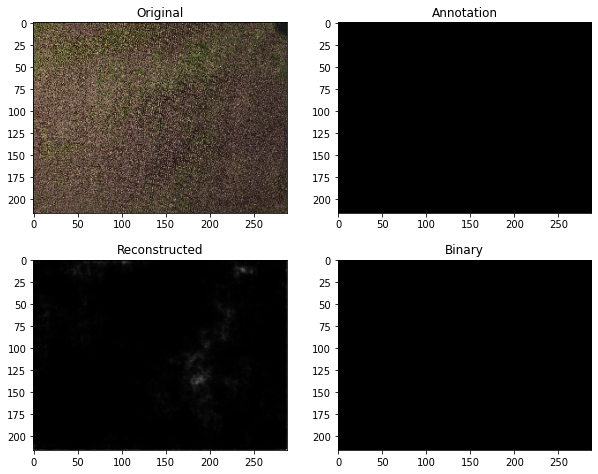

In [16]:
# Visualization Original and Reconstructed Images
# images, labels = iter(test_loader).next()
idx = int(np.random.uniform(high = len(testX_data)))
img, label, img_ae = testX_data[idx, :, :, :], testY_data[idx, 0, :, :], test_out[idx, 0, :, :]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# img = images[0, :, :, :].permute(1, 2, 0)
axs[0, 0].imshow(img.permute(1, 2, 0))
axs[0, 0].title.set_text('Original')
axs[0, 1].imshow(label, cmap = 'gray')

axs[0, 1].title.set_text('Annotation')
# images = images.to(device)
# images_ae = ae_model(images)
# img_ae = images_ae[1][0, 0, :, :]
# img_ae = img_ae.detach().cpu()
axs[1, 0].imshow(img_ae, cmap = 'gray')
axs[1, 0].title.set_text('Reconstructed')
img_bool = img_ae > 0.5
axs[1, 1].imshow(img_bool, cmap = 'gray')
axs[1, 1].title.set_text('Binary')



In [17]:
# Getting Data
# trainX_tensor = trainX_data.to(device) # Move to GPU
# trainY_tensor = trainY_data.to(device)

# validX_tensor = validX_data.to(device)
# validY_tensor = validY_data.to(device)


# testX_tensor = testX_data.to(device) # this takes a lot of GPU memory (about 5 Gb)
# testY_tensor = testY_data.to(device)

# Forward in trained model
# _,train_out = ae_model(trainX_tensor) 
# _,valid_out = ae_model(validX_tensor) 
# _,test_out = ae_model(testX_tensor) 
print( test_out.shape) #train_out.shape, valid_out.shape,

torch.Size([89, 1, 216, 288])


In [18]:
#Fix Dimensions
# train_outf = F.interpolate(train_out, size = images.shape[2:4])
# valid_outf = F.interpolate(valid_out, size = images.shape[2:4])
# test_outf = F.interpolate(test_out, size = images.shape[2:4])
# print(train_outf.shape, valid_outf.shape, test_outf.shape)

In [19]:
#Binary output image
# train_boolf = train_outf > 0.5
# valid_boolf = valid_outf > 0.5
test_boolf = test_out > 0.5

#For accuracy scores
# train_true = trainY_tensor.flatten()
# train_pred = train_boolf.flatten()
# valid_true = validY_tensor.flatten()
# valid_pred = valid_boolf.flatten()
test_true = testY_data.flatten()
test_pred = test_boolf.flatten()
#print(train_true.shape, train_pred.shape)
#print(valid_true.shape, valid_pred.shape)
#print(test_true.shape, test_pred.shape)

## Jaccard Index

In [20]:
# train_iou = jaccard_score(train_true.detach().cpu(), train_pred.detach().cpu(), average='binary')
# print('Jaccard index for train: %f' % (train_iou))
# valid_iou = jaccard_score(valid_true.detach().cpu(), valid_pred.detach().cpu(), average='binary')
# print('Jaccard index for valid: %f' % (valid_iou))
# test_iou = jaccard_score(test_true.detach().cpu(), test_pred.detach().cpu(), average='binary')
test_iou = jaccard_score(test_true.detach(), test_pred.detach(), average='binary')
print('Jaccard index for test: %f' % (test_iou))

Jaccard index for test: 0.810057


## Dice Coefficient

In [21]:
# train_intersection = np.logical_and(train_true.detach().cpu(), train_pred.detach().cpu())
# train_dice = 2 * train_intersection.sum() / (train_true.sum() + train_pred.sum())
# print('Dice Coefficient for train: %f' % (train_dice))

# valid_intersection = np.logical_and(valid_true.detach().cpu(), valid_pred.detach().cpu())
# valid_dice = 2 * valid_intersection.sum() / (valid_true.sum() + valid_pred.sum())
# print('Dice Coefficient for valid: %f' % (valid_dice))

test_intersection = np.logical_and(test_true.detach(), test_pred.detach())
test_dice = 2 * test_intersection.sum() / (test_true.sum() + test_pred.sum())
print('Dice Coefficient for test: %f' % (test_dice))

Dice Coefficient for test: 0.895062


In [22]:
def get_confusion_matrix_intersection_mats(groundtruth, predicted):
  confusion_matrix_arrs = {}
  groundtruth_inverse = np.logical_not(groundtruth)
  predicted_inverse = np.logical_not(predicted)

  confusion_matrix_arrs['tp'] = np.logical_and(groundtruth, predicted)
  confusion_matrix_arrs['tn'] = np.logical_and(groundtruth_inverse, predicted_inverse)
  confusion_matrix_arrs['fp'] = np.logical_and(groundtruth_inverse, predicted)
  confusion_matrix_arrs['fn'] = np.logical_and(groundtruth, predicted_inverse)
  return confusion_matrix_arrs

def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, alpha, colors):
  """ Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
  each a color given by the 'colors' dictionary """
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
  color_mask = np.zeros_like(image)
  for label, mask in masks.items():
    color = colors[label]
    mask_rgb = np.zeros_like(image)
    mask_rgb[mask != 0] = color
    color_mask += mask_rgb
  return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)

alpha = 0.5
confusion_matrix_colors = {
   'tp': (255, 255, 255),  #white
   'fp': (255, 0, 0),  #red
   'fn': (0, 0, 255),  #blue
   'tn': (0, 0, 0)     #black
   }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


White - True Positive
Red - False Positive
Blue - False Negative
Black - True Negative


Text(0.5, 1.0, 'Confusion Matrix Overlay Mask')

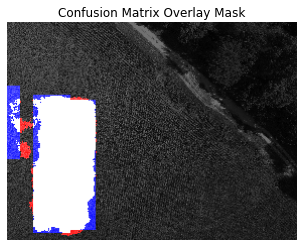

In [50]:
#validation_mask = get_confusion_matrix_overlaid_mask(255 - grayscale, groundtruth, predicted, alpha, confusion_matrix_colors)
i = int(np.random.uniform(high = len(testX_data)))
validation_mask = get_confusion_matrix_overlaid_mask(np.float32(testX_data[i,0]), np.float32(testY_data[i,0]), test_boolf[i,0], alpha, confusion_matrix_colors)
print('White - True Positive')
print('Red - False Positive')
print('Blue - False Negative')
print('Black - True Negative')
plt.imshow(validation_mask)
plt.axis('off')
plt.title('Confusion Matrix Overlay Mask')

# Test Dataset
Generate Test Dataset predictions and store them.

**TODO:** Make this code work

In [51]:
# Test Dataset
#test_files = np.array(glob.glob(os.path.join(path, "/Test/*.jpg")))
test_path = "/content/drive/My Drive/ECE_542-Project_2/Data/Test"
test_files = np.array(glob.glob(os.path.join(test_path, "*.jpg")))

test_files = sorted(test_files)

# Pytorch Dataset
test_dataset = Image_Dataset(test_files, test_files, transform = composed)

# Pytorch Dataloader
test_data_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

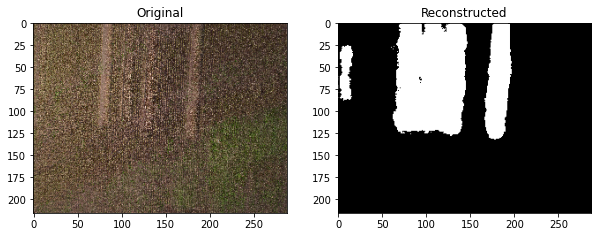

In [56]:
# Visualization Original and Reconstructed Images
images, labels = iter(test_data_loader).next()
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
img = images[0].permute(1, 2, 0)
axs[0].imshow(img)
axs[0].title.set_text('Original')
images = images.to(device)
_, images_ae = ae_model(images)

img_ae = images_ae[0, 0, :, :] # [idx batch, channel, width, hegith]
img_ae = img_ae.detach().cpu()

img_bool = img_ae > 0.5
axs[1].imshow(img_bool, cmap = 'gray')
axs[1].title.set_text('Reconstructed')

## Storing Images

In [71]:
if store_predictions:
  # Predict Path
  predict_path = "/content/drive/My Drive/ECE_542-Project_2/Predict_segnet/"
  # Pytorch Dataloader
  # test_data_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 2)
  # Plot Images
  c = 0
  for test_images,_ in test_data_loader:
    # Forward in AE
    with torch.no_grad():
      test_images = test_images.to(device)
      _, recon_images = ae_model(test_images)
      recon_images = recon_images.detach().cpu()
      # mask_images = torch.argmax(recon_images, dim = 1)
      # mask_images = recon_images[:][0, 0, :, :]
      mask_images = recon_images > 0.5
      # Upsample Image and store in predict path
      for i in range(len(mask_images)):
        mask_img = mask_images[i]
        mask_img = torch.unsqueeze(mask_img, dim = 0).float() # (Batch x Channel x Height x Width) format
        mask_img = F.interpolate(mask_img, size = real_size) # resize image to match input size
        mask_name = test_files[i + batch_size * c][-8:][:4] + ".png" # generate image name
        save_image(mask_img, predict_path + mask_name)
      c += 1